# Notebooks para estudar os dados do Daylio


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.optimize as opt
from pandas.tools.plotting import table
import statsmodels.api as sm
import scipy.fftpack as fft

## Custom definitions

In [2]:
# Put here the score for each custom mood in Daylio
mood_score = {"awful": 0, "melancholic": 0, "aaa": 0,
              "bad": 1, "shitty": 1, "grr": 1,
              "aff":2, "zzz": 2, "meh": 2,
              "good": 3, "satisfied": 3, "gogo": 3,
              "rad": 4, "wonderful": 4, "hihi": 4}

# When doing visualizations and data-fitting, only consider activities with more than N points
activities_N_minimum = 19


## Data preparation

In [3]:
# Preparar dados do humor
raw_mood_data = pd.read_csv("daylio_export.csv", parse_dates=[[0, 1, 2, 3]], index_col="year_date_weekday_time")
raw_mood_data = raw_mood_data.replace({"mood": mood_score}).copy()
raw_mood_data = raw_mood_data.replace(np.nan, "")
mood_data = raw_mood_data.copy()


# Normalize mood score to an domain between 0 and 100
mood_data.mood *= 100
mood_data.mood /= 4

In [4]:
# Separate the activities on each row

activities_string = " | ".join(mood_data.activities.values)
activities_string = activities_string.split(" | ")
unique_activities = np.unique(activities_string)
unique_activities = unique_activities[unique_activities != ""]
mood_data.activities = mood_data.activities.str.split(" \| ")

In [5]:
# Generate new columns with the activities
for activity in unique_activities:
    contains_activity = mood_data.activities.apply(lambda x: activity in x)
    mood_data[activity] = contains_activity

## Visualization

In [6]:
resample_rule = "7d"

daily_mood = mood_data.resample(resample_rule).mean().mood

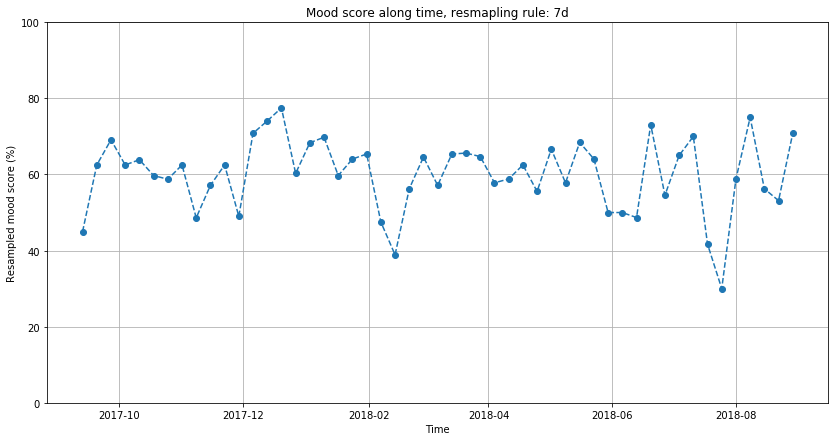

In [7]:
plt.figure(figsize=(14, 7))
plt.grid()
plt.plot(daily_mood, "--o")
#plt.plot(mood_data[mood_data.sick == True].mood, 'o')
plt.ylim((0, 100))
plt.title("Mood score along time, resmapling rule: {}".format(resample_rule))
plt.ylabel("Resampled mood score (%)")
plt.xlabel("Time")
plt.show()

In [8]:
# Get list of activities which has more than activities_N_minimum points (user-defined)

unique_activities_2 = []
for activity in unique_activities:
    if mood_data[activity].sum() > activities_N_minimum:
        unique_activities_2.append(activity)

In [9]:
# Do an multilinear fitting on the data

N_samples = len(mood_data)
N_features = len(unique_activities_2)
features = []

X = np.zeros((N_samples, N_features))
Y = np.array(mood_data.mood.values)
for i in range(N_features):
    feature = unique_activities_2[i]
    features.append(feature)
    X[:, i] = mood_data[feature].astype(int)

X = sm.add_constant(X)
est = sm.OLS(Y, X).fit()

summary = est.summary()
cov_mtr = est.cov_params() # covariance matrix
diag = np.diag(np.diag(cov_mtr))
D = np.linalg.inv(np.sqrt(diag))
r = np.matmul(D, np.matmul(cov_mtr, D)) # correlation matrix

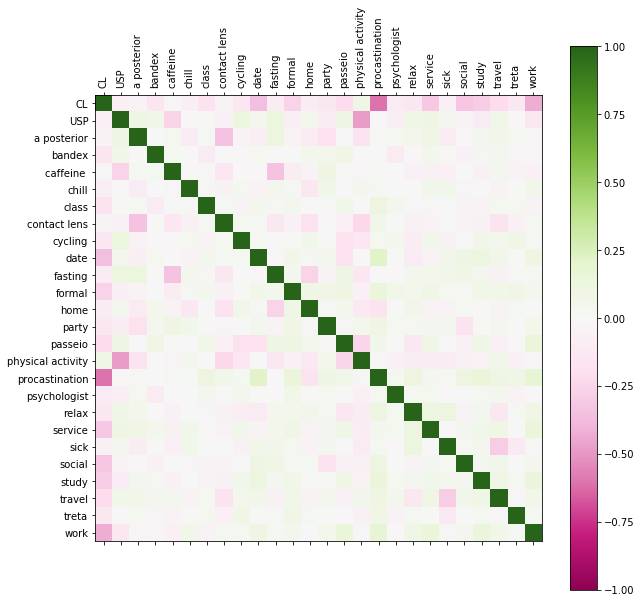

In [10]:
# Plot the correlation matrix for the multilinear fit

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
mtr = ax.matshow(r, vmin=-1, vmax=1, cmap="PiYG")
plt.colorbar(mtr)
ax.set_xticks(np.arange(r.shape[0]))
ax.set_xticklabels(["CL"] + unique_activities_2, rotation="vertical")
ax.set_yticks(np.arange(r.shape[0]))
ax.set_yticklabels(["CL"] + unique_activities_2, rotation="horizontal")
plt.show()

In [11]:
# Transforming the summary table into something more readable

i = 0
for activity in unique_activities_2:
    summary.tables[1][2:][i][0].data = activity
    i += 1

In [12]:
# Show the summary of the multilinear fit

# Rough (and technically wrong) meanings of the columns
# [coef] how much (+/-)% the activity has influence on the mood score (on average)
# [std err] the dispersion of the [coef]
# [t] measure of the reliability for the [coef] estimation.
# |t|=2 means about 95% chance of being right and |t|>2 means about 99% chance of being ok. |t|=1 is about 68% 

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     13.22
Date:                Tue, 04 Sep 2018   Prob (F-statistic):           4.00e-45
Time:                        13:03:16   Log-Likelihood:                -3571.3
No. Observations:                 833   AIC:                             7195.
Df Residuals:                     807   BIC:                             7317.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                54.5210      1.586     34.373      0.000      51.407      57.634
USP                   5.1119      2.533      2.018      0.044       0.139      10.085
a posterior          -2.7219      2.250     -1.210      0.227      -7.139       1.695
bandex                1.5685      2.852      0.550      0.582      -4.029       7.166
caffeine              0.3053      2.114      0.144      0.885      -3.843       4.454
chill                 6.8547      3.209      2.136      0.033       0.557      13.153
class                -1.8198      3.432     -0.530      0.596      -8.557       4.918
contact lens         -1.7243      2.110     -0.817      0.414      -5.866       2.418
cycling               0.9111      2.520      0.361      0.718      -4.036       5.858
date                  6.4735      1.646      3.932      0.000       3.242       9.705
fasting               2.2845      2.460      0.929      0.353      -2.545       7.114
formal                1.1135      2.548      0.437      0.662      -3.887       6.114
home                 -3.5779      1.865     -1.918      0.055      -7.239       0.083
party                -2.6290      3.938     -0.668      0.505     -10.359       5.101
passeio               5.7355      1.851      3.099      0.002       2.103       9.368
physical activity     0.5302      2.401      0.221      0.825      -4.183       5.243
procastination       -2.5270      1.435     -1.761      0.079      -5.343       0.289
psychologist          1.1910      3.367      0.354      0.724      -5.418       7.800
relax                16.0155      2.854      5.612      0.000      10.414      21.617
service               3.7127      1.827      2.032      0.042       0.126       7.299
sick                -10.0804      3.203     -3.147      0.002     -16.368      -3.793
social               11.8796      1.422      8.354      0.000       9.088      14.671
study                -0.5976      2.241     -0.267      0.790      -4.997       3.802
travel               -4.5606      2.446     -1.864      0.063      -9.362       0.241
treta               -22.7499      2.793     -8.146      0.000     -28.232     -17.268
work                  5.1111      1.599      3.197      0.001       1.973       8.249
==============================================================================
Omnibus:                       24.242   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.602
Skew:                          -0.412   Prob(JB):                     2.76e-06
Kurtosis:                       3.242   Cond. No.                         8.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""